## TWENTY NEXS GROUPS ONE SHOT CLASSIFICATION USING SENTENCE TRANSFORMER

TASKS : </br> 

1. Create a custom loading class, compatible with Pytorch
DataLoader, that generates training triplets (anchor, positive example,
negative example) from 20 Newsgroups.</br> You might want to take a look at the
SentenceLabelDataset class```
https://github.com/UKPLab/sentence-transformers/blob/6fcfdfb30f9dfcc5fb97
8c97ce02941a7aa6ba63/sentence_transformers/datasets/SentenceLabelDataset.py```.</br>
You should come up with a strategy to generate triplets that will be the most helpful
/ insightful for the model to train with.</br>

2. Build a training pipeline and fine-tune a ```distilbert-base-nli-mean-tokens```
model with your custom loading class, using the ```TripletLoss``` loss function. </br>
Since fine-tuning is quite time-consuming, even on a GPU, you can go for a
single epoch. Your triplet generation strategy is what matters to us.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U sentence-transformers

In [14]:
# Dependencies importation

import os
import logging
import random
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sentence_transformers.readers import InputExample
from sentence_transformers import LoggingHandler, losses, SentenceTransformer
from sentence_transformers.evaluation import TripletEvaluator
from torch.utils.data import DataLoader


## Data importation and vizualisation

Before data processing, we plot some features. For that, we create some data importation functions

In [4]:
def get_dataframe_from_ng() : 
    df_list = []
    for subset in ["train", "test"] : 
        data = fetch_20newsgroups(subset=subset, remove=("headers", "footers","quotes"), shuffle=True)
        df = pd.DataFrame({
            "data" : data.data,
            "labels" : data.target
        })
        df['data'].replace('', np.nan, inplace=True)
        df.dropna(inplace=True)
        df_list.append(df)
    return df_list

# We split data in train eval and test dataframe 
df_train, df_test = get_dataframe_from_ng()
df_test, df_eval = train_test_split(
    df_test,
    test_size=0.5,
    shuffle = True,
)

print(
    f" train size : {len(df_train)}" \
    f" eval size : {len(df_eval)}" \
    f" test size : {len(df_test)}" \
)


 train size : 11096 eval size : 3685 test size : 3685


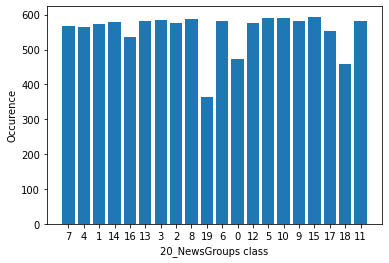

In [5]:
# Plot occurence of each class in the train data
count = Counter(df_train.labels)
bar = [str(x) for x in count.keys()]
height = list(count.values())
plt.bar(bar,count.values())
plt.xlabel("20_NewsGroups class")
plt.ylabel("Occurence")
plt.show()

In [6]:
## Number of tokens by sentence

tokens = [len(sentence.split()) for sentence in df_train.data]
pd.Series(tokens).describe()

count    11096.000000
mean       189.478280
std        528.440043
min          0.000000
25%         42.000000
50%         86.000000
75%        170.000000
max      11765.000000
dtype: float64

## Fine-tuning using ```distilbert-base-nli-mean-tokens```

In the last version of ```sentence_transformers```, according to this <a href  = https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark.py >link</a>, We won't need a Dataset class to train with ```sentence_transformers```. Juste a list of ```InputExample``` is enougth. Let's create it

In [7]:
def get_input_example(df : pd.DataFrame) : 

    examples = []
    for i, (text, label) in enumerate(zip(df.data.values, df.labels.values)) :
        examples.append(InputExample(guid=i, texts=[text], label=label))

    return examples


def get_triplets_input_example(df : pd.DataFrame) : 

    index = df.index.values
    
    triplets_input_examples = []

    for ind, anchor, anchor_label in zip(df.index, df.data, df.labels) : 

        positive_list = index[index!=ind][df["labels"][index!=ind]==anchor_label]
        positive_item = random.choice(positive_list)
        positive_example = df["data"].loc[positive_item]

        negative_list = index[index!=ind][df["labels"][index!=ind]!=anchor_label]
        negative_item = random.choice(negative_list)
        negative_example = df["data"].loc[negative_item]

        triplets_input_examples.append(InputExample(texts = [anchor, positive_example, negative_example], label = anchor_label))

    return triplets_input_examples

In [8]:
# Get training_examples
train_examples = get_triplets_input_example(df_train)

In [9]:
# Logging Configuration 
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

# Continue training distilbert-base-nli-mean-tokens on 20news_groups data
MODEL_NAME = 'distilbert-base-nli-mean-tokens'

### Create a torch.DataLoader that passes training batch to our model
BATCH_SIZE = 16

# Load pretrained model
model = SentenceTransformer(MODEL_NAME)

logging.info("Read 20Newsgroups data")

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE )
train_loss = losses.TripletLoss(model)

2021-10-04 06:45:10 - Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens
2021-10-04 06:45:12 - Lock 140567195153744 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/.gitattributes.lock


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

2021-10-04 06:45:13 - Lock 140567195153744 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/.gitattributes.lock
2021-10-04 06:45:13 - Lock 140569997248144 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/README.md.lock


Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

2021-10-04 06:45:14 - Lock 140569997248144 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/README.md.lock
2021-10-04 06:45:15 - Lock 140567195153744 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/config.json.lock


Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

2021-10-04 06:45:16 - Lock 140567195153744 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/config.json.lock
2021-10-04 06:45:17 - Lock 140569997248144 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/config_sentence_transformers.json.lock


Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

2021-10-04 06:45:17 - Lock 140569997248144 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/config_sentence_transformers.json.lock
2021-10-04 06:45:18 - Lock 140567194461904 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/modules.json.lock


Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

2021-10-04 06:45:19 - Lock 140567194461904 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/modules.json.lock
2021-10-04 06:45:20 - Lock 140569997248144 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/pytorch_model.bin.lock


Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

2021-10-04 06:45:28 - Lock 140569997248144 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/pytorch_model.bin.lock
2021-10-04 06:45:29 - Lock 140567190974096 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/sentence_bert_config.json.lock


Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

2021-10-04 06:45:30 - Lock 140567190974096 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/sentence_bert_config.json.lock
2021-10-04 06:45:31 - Lock 140567190973648 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/special_tokens_map.json.lock


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

2021-10-04 06:45:32 - Lock 140567190973648 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/special_tokens_map.json.lock
2021-10-04 06:45:32 - Lock 140567190945232 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/tokenizer.json.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

2021-10-04 06:45:34 - Lock 140567190945232 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/tokenizer.json.lock
2021-10-04 06:45:35 - Lock 140567194461776 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/tokenizer_config.json.lock


Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

2021-10-04 06:45:36 - Lock 140567194461776 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/tokenizer_config.json.lock
2021-10-04 06:45:37 - Lock 140567190347664 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/vocab.txt.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

2021-10-04 06:45:38 - Lock 140567190347664 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/vocab.txt.lock
2021-10-04 06:45:39 - Lock 140567183733904 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/1_Pooling/config.json.lock


Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

2021-10-04 06:45:40 - Lock 140567183733904 released on /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/1_Pooling/config.json.lock
2021-10-04 06:45:41 - Use pytorch device: cuda
2021-10-04 06:45:41 - Read 20Newsgroups data


In [10]:
### Model accuracy before fine tuning
eval_triplets_examples = get_triplets_input_example(df_eval)

logging.info("Evaluation ...")
dev_evaluator = TripletEvaluator.from_input_examples(eval_triplets_examples,  name='20_ng_eval')
logging.info("Accuracy :")
dev_evaluator(model)

2021-10-04 06:46:41 - Evaluation ...
2021-10-04 06:46:41 - Accuracy :
2021-10-04 06:46:41 - TripletEvaluator: Evaluating the model on 20_ng_eval dataset:


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


2021-10-04 06:48:09 - Accuracy Cosine Distance:   	66.30
2021-10-04 06:48:09 - Accuracy Manhatten Distance:	66.16
2021-10-04 06:48:09 - Accuracy Euclidean Distance:	66.05



0.6629579375848033

In [17]:
EPOCHS = 1
BATCH_SIZE = 32
OUTPUT_PATH = "./models"

if not os.path.exists('/content/drive/MyDrive/Vocads/models'):
    os.makedirs('/content/drive/My Drive/Vocads/models')

OUTPUT_PATH = ("/content/drive/My Drive/Vocads/models/")

### Model Fune tuning
warmup_steps = int(len(train_examples) * EPOCHS / BATCH_SIZE * 0.1)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=EPOCHS,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
    output_path=OUTPUT_PATH,
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/694 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


2021-10-04 07:25:19 - TripletEvaluator: Evaluating the model on 20_ng_eval dataset after epoch 0:
2021-10-04 07:26:35 - Accuracy Cosine Distance:   	87.87
2021-10-04 07:26:35 - Accuracy Manhatten Distance:	87.82
2021-10-04 07:26:35 - Accuracy Euclidean Distance:	87.76

2021-10-04 07:26:35 - Save model to /content/drive/My Drive/Vocads/Output/models/


In [18]:

### Model accuracy after fine tuning
test_triplets_examples = get_triplets_input_example(df_test)

logging.info("Evaluation on test")
test_evaluator = TripletEvaluator.from_input_examples(test_triplets_examples,  name='20_ng_test')
logging.info("Accuracy : ")
test_evaluator(model)

2021-10-04 07:28:20 - Evaluation on test
2021-10-04 07:28:20 - Accuracy : 
2021-10-04 07:28:20 - TripletEvaluator: Evaluating the model on 20_ng_test dataset:


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


2021-10-04 07:29:36 - Accuracy Cosine Distance:   	87.57
2021-10-04 07:29:36 - Accuracy Manhatten Distance:	87.49
2021-10-04 07:29:36 - Accuracy Euclidean Distance:	87.76



0.8776119402985074

In [19]:
# Load sBert pretrained model
SBERT_MODEL_NAME = "all-MiniLM-L6-v2"
model = SentenceTransformer(SBERT_MODEL_NAME)

logging.info("Evaluation on test")
test_evaluator = TripletEvaluator.from_input_examples(eval_triplets_examples,  name='20_ng_test')
logging.info("Accuracy : ")
test_evaluator(model)

2021-10-04 07:29:55 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2021-10-04 07:29:57 - Lock 140567179415504 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/.gitattributes.lock


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

2021-10-04 07:29:58 - Lock 140567179415504 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/.gitattributes.lock
2021-10-04 07:29:58 - Lock 140567179161104 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/README.md.lock


Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

2021-10-04 07:29:59 - Lock 140567179161104 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/README.md.lock
2021-10-04 07:30:00 - Lock 140567180479760 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json.lock


Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

2021-10-04 07:30:01 - Lock 140567180479760 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json.lock
2021-10-04 07:30:02 - Lock 140567180775504 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config_sentence_transformers.json.lock


Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

2021-10-04 07:30:02 - Lock 140567180775504 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config_sentence_transformers.json.lock
2021-10-04 07:30:03 - Lock 140567180522448 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/data_config.json.lock


Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

2021-10-04 07:30:04 - Lock 140567180522448 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/data_config.json.lock
2021-10-04 07:30:05 - Lock 140567181299408 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/modules.json.lock


Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

2021-10-04 07:30:06 - Lock 140567181299408 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/modules.json.lock
2021-10-04 07:30:07 - Lock 140567181299408 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin.lock


Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

2021-10-04 07:30:10 - Lock 140567181299408 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin.lock
2021-10-04 07:30:10 - Lock 140567180523792 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/sentence_bert_config.json.lock


Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

2021-10-04 07:30:11 - Lock 140567180523792 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/sentence_bert_config.json.lock
2021-10-04 07:30:12 - Lock 140567180776656 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/special_tokens_map.json.lock


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

2021-10-04 07:30:13 - Lock 140567180776656 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/special_tokens_map.json.lock
2021-10-04 07:30:13 - Lock 140567180479504 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer.json.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

2021-10-04 07:30:15 - Lock 140567180479504 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer.json.lock
2021-10-04 07:30:16 - Lock 140567179161040 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer_config.json.lock


Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

2021-10-04 07:30:17 - Lock 140567179161040 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer_config.json.lock
2021-10-04 07:30:18 - Lock 140567180480336 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/train_script.py.lock


Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

2021-10-04 07:30:18 - Lock 140567180480336 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/train_script.py.lock
2021-10-04 07:30:19 - Lock 140567180776656 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/vocab.txt.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

2021-10-04 07:30:21 - Lock 140567180776656 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/vocab.txt.lock
2021-10-04 07:30:22 - Lock 140567180522512 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/1_Pooling/config.json.lock


Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

2021-10-04 07:30:23 - Lock 140567180522512 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/1_Pooling/config.json.lock
2021-10-04 07:30:23 - Use pytorch device: cuda
2021-10-04 07:30:23 - Evaluation on test
2021-10-04 07:30:23 - Accuracy : 
2021-10-04 07:30:23 - TripletEvaluator: Evaluating the model on 20_ng_test dataset:


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


2021-10-04 07:31:13 - Accuracy Cosine Distance:   	77.61
2021-10-04 07:31:13 - Accuracy Manhatten Distance:	76.91
2021-10-04 07:31:13 - Accuracy Euclidean Distance:	77.61



0.7761194029850746

## Conclusion

We got  **accuracy increase** (20%) after fine-tuning to **~88%**. Our model has better than the sBERT pretrained model ```all-MiniLM-L6-v2``` of **10** points.